# Importación de librerias

In [1]:
import numbers
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, recall_score, f1_score, classification_report, confusion_matrix
from scipy.spatial import distance
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from pprint import pprint
import seaborn as sns

In [2]:
model_name = "Random Forest"

In [3]:
#Metodo para convertir milisegundos a segundos
def mili_to_seconds(mls):
    return mls / 1000

In [4]:
"""
Método de función para encontrar el valor más cercano en un array
Parámetros
----------
array : array
value : valor que se debe de encontrar más cercano

Retorno
-------
Indice en el array y su valor respectivo en el array
"""
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def find_fpr_and_tpr_given_a_threshold(genuine_scores, impostor_scores, threshold):
    labels = [1] * len(genuine_scores) + [0] * len(impostor_scores)
    fprs, tprs, thresholds = roc_curve(labels, genuine_scores + impostor_scores, pos_label = 1)
    idx, value = find_nearest(thresholds, threshold)
    return fprs[idx], tprs[idx], value

# Definición del método para evaluar el mejor modelo

In [5]:
def evaluate_Model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy )
    return accuracy

# Definición del método para el cálculo del AUC

In [6]:
"""
Método para el cálculo del Area Under the Curve
Parámetros
----------
user_scores : array con los scores o distancias del usuario legítimo
impostor_scores : array con los scores o distancias de usuarios ilegítimos

Retorno
-------
AUC: area bajo la curva ROC
"""
def evaluate_AUC(genuine_scores, impostor_scores):
    #Se etiquetan los usuarios legítimos con 1 e impostores con 0
    labels = [1] * len(genuine_scores) + [0] * len(impostor_scores)
    auc_score = roc_auc_score(labels, genuine_scores + impostor_scores)
    return auc_score

In [7]:
"""
Método para el cálculo del ERR
Parámetros
----------
user_scores : array con los scores o distancias del usuario legítimo
impostor_scores : array con los scores o distancias de usuarios ilegítimos

Retorno
-------
Equal Error Rate: punto donde los missrates y los far
"""
#Primera forma de hallar el ERR
def evaluate_EER(genuine_scores, impostor_scores):
    #Se etiquetan los usuarios legítimos con 1 e impostores con 0
    labels = [1] * len(genuine_scores) + [0] * len(impostor_scores)
    
    #Se utiliza el metodo de roc_curve para hallar los fpr, tpr y umbrales
    fpr, tpr, thresholds = roc_curve(labels, genuine_scores + impostor_scores, pos_label = 1)
    
    #Variable con los False Negative Rate (FNR) - miss
    missrates = 1 - tpr
    
    #Variable con los False Positive Rate (FPR) - false alarm
    farates = fpr
    
    #Se hallan las distancias entre los FNR y FPR dado cierto umbral
    dists = missrates - farates
    
    #Listas que separan las distancias con los valores 
    #que estan más cercano al cero tanto superior como inferior
    tempList1 = dists[dists >= 0]
    tempList2 = dists[dists < 0]
    
    #Se busca el punto en la curva ROC donde se interceptan geométricamente el FNR y FPR
    #El primero que sea el cercano superior al false alarm (>=)
    #y aquel que este pegado a este en la curva pero siendo el cercano inferior (<)
    # argmin te arroja el indice el item con los menores valores
    # argmax te arroja el indice el item con los mayores valores
    #idx es una variable que almacena este índice
    
    #Indice del menor elemento del tempList1 (Lo más pegado al cero superiormente)
    idx1 = np.argmin(tempList1)
    #Sacar el indice del valor de idx1 (en tempList1), pero en la lista "dists"
    idx1, = np.where(dists == tempList1[idx1])
    
    #Indice del mayor elemento del tempList2 (Lo más pegado al cero inferiormente)
    idx2 = np.argmax(tempList2)
    #Sacar el indice del valor de idx2 (en tempList2), pero en la lista "dists"
    idx2, = np.where(dists == tempList2[idx2])
    
    #Se determina es valor de los dos puntos y ponerlo en la variable x e y
    x = [missrates[idx1], farates[idx1]]
    y = [missrates[idx2], farates[idx2]]

    #encuentrar el punto en la línea entre x e y en donde 
    #los primeros y segundos elementos del vector sean iguales.
    #Específicamente, la línea que pasa a través de x e y 
    #se define como x + a * (y-x) para todo "a"
    #Si usamos esta formula y lo igualamos, ya q x e y 
    #deben de coincidir en ese punto de la recta
    #  -> x[1] + a*(y[1]-x[1]) = x[2] + a*(y[2]-x[2])
    #lo factorizamos para determinar a
    #que seria la pendiente de la recta que construiremos
    #  -> a = (x[1] - x[2]) / (y[2]-x[2]-y[1]+x[1]) 
    
    a = ( x[0] - x[1] ) / ( y[1] - x[1] - y[0] + x[0] )
    eer = x[0] + a * ( y[0] - x[0] )
    
    return eer


#Segunda forma de hallar el EER.
def evaluate_EER_Thresh(genuine_scores, impostor_scores):
    
    #Se etiquetan los usuarios legítimos con 1 e impostores con 0
    labels = [1]*len(genuine_scores) + [0]*len(impostor_scores)
    
    #Se utiliza el metodo de roc_curve para hallar los fpr, tpr y umbrales
    fpr, tpr, thresholds = roc_curve(labels, genuine_scores + impostor_scores, pos_label = 1)
    
    #Se calcula el EER cuando el punto del fpr y del fpr se encuentran
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    
    thresh = interp1d(fpr, thresholds)(eer)
    return eer, thresh

# Definición del método para graficar curva ROC

In [8]:
def plotCurveROC(genuine_scores, impostor_scores, title = 'Receiver Operating Characteristic'):
    
    #Se etiquetan los usuarios legítimos con 1 e impostores con 0
    labels = [1] * len(genuine_scores) + [0] * len(impostor_scores)
    
    #Se utiliza el metodo de roc_curve para hallar los fpr, tpr y umbrales
    fpr, tpr, thresholds = roc_curve(labels, genuine_scores + impostor_scores, pos_label = 1)
    
    roc_auc = evaluate_AUC(genuine_scores, impostor_scores)
    
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def plotCurveROC_Threshold(genuine_scores, impostor_scores, threshold_value , threshold_x, threshold_y , color = "green" , title = 'Receiver Operating Characteristic'):
    #Se etiquetan los usuarios legítimos con 1 e impostores con 0
    labels = [1] * len(genuine_scores) + [0] * len(impostor_scores)
    
    #Se utiliza el metodo de roc_curve para hallar los fpr, tpr y umbrales
    fpr, tpr, thresholds = roc_curve(labels, genuine_scores + impostor_scores, pos_label = 1)
    
    roc_auc = evaluate_AUC(genuine_scores, impostor_scores)
    
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.scatter(threshold_x ,threshold_y, color = color)
    plt.text(threshold_x + 0.025, threshold_y - 0.05 , threshold_value)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Definición del método para graficar matriz de confusión

In [9]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, title = "CM"):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Lectura de archivo y eliminación de registros no válidos
### Registros de Usuarios

In [10]:
df = pd.read_csv('./data/lo/11_17/records.csv', parse_dates=['date'])
df.drop(columns=['__v'], inplace = True)

df = df[df.valid == True]

Script para generar los vectores de tiempo

In [11]:
def pp_array_convert(raw_json_press, raw_json_release):
    parsed_json_press = json.loads(raw_json_press)
    arr = []
    length = len(parsed_json_press)
    for idx in range(length - 1):
        value =  float(parsed_json_press[idx + 1]['timeStamp']) - float(parsed_json_press[idx]['timeStamp'])
        arr.append(value)
    return arr

def rr_array_convert(raw_json_press, raw_json_release):
    parsed_json_release = json.loads(raw_json_release)
    arr = []
    length = len(parsed_json_release)
    for idx in range(length - 1):
        value =  float(parsed_json_release[idx + 1]['timeStamp']) - float(parsed_json_release[idx]['timeStamp'])
        arr.append(value)
    return arr

def pr_array_convert(raw_json_press, raw_json_release):
    parsed_json_press = json.loads(raw_json_press)
    parsed_json_release = json.loads(raw_json_release)
    arr = []
    length = len(parsed_json_press)

    if len(parsed_json_press) != len(parsed_json_release):
        return np.nan
    else:
        for idx in range(length - 1):
            value = float(parsed_json_release[idx + 1]['timeStamp']) - float(parsed_json_press[idx]['timeStamp'])
            arr.append(value)
    return arr

def rp_array_convert(raw_json_press, raw_json_release):
    parsed_json_press = json.loads(raw_json_press)
    parsed_json_release = json.loads(raw_json_release)
    arr = []
    length = len(parsed_json_press)

    if len(parsed_json_press) != len(parsed_json_release):
        return np.nan
    else:
        for idx in range(length - 1):
            value = float(parsed_json_press[idx + 1]['timeStamp']) - float(parsed_json_release[idx]['timeStamp'])
            arr.append(value)
    return arr

def merge_arrays(ppTimeArray, rrTimeArray, prTimeArray, rpTimeArray):
    
    arr1 = np.array(ppTimeArray)
    arr2 = np.array(rrTimeArray)
    arr3 = np.array(prTimeArray)
    arr4 = np.array(rpTimeArray)

    arr = np.concatenate((arr1, arr2, arr3, arr4))
    return arr

In [12]:
def getVentorLen(passwordLen):
    return (passwordLen - 1) * 4

Ejecución de scripts

In [13]:
df['ppTime'] = df.apply(lambda x: pp_array_convert(x['rawPasswordKeydown'], x['rawPasswordKeyup']), axis=1)
df['rrTime'] = df.apply(lambda x: rr_array_convert(x['rawPasswordKeydown'], x['rawPasswordKeyup']), axis=1)
df['prTime'] = df.apply(lambda x: pr_array_convert(x['rawPasswordKeydown'], x['rawPasswordKeyup']), axis=1)
df['rpTime'] = df.apply(lambda x: rp_array_convert(x['rawPasswordKeydown'], x['rawPasswordKeyup']), axis=1)

df.dropna(inplace = True)

df['vector'] = df.apply(lambda x: merge_arrays(x['ppTime'], x['rrTime'], x['prTime'], x['rpTime']), axis=1)

df.drop(['sessionIndex','date','rawUsernameKeydown', 'rawUsernameKeyup', 'rawPasswordKeydown', 'rawPasswordKeyup', 'ipAddress', 'userAgent', 'token', 'username'], axis=1, inplace = True)

In [14]:
df['passLen'] = df.apply(lambda x: len(x['password']), axis=1)
df['vectorLen'] = df.apply(lambda x: len(x['vector']), axis=1)

In [15]:
#Filtrar constraseñas de tamaño fijo
df = df[df['passLen'] == 9]

In [16]:
#df.drop(['date'], axis=1, inplace = True)
#df.to_excel("output.xlsx")

# Previsualización del dataset original
 El siguiente dataset contiene las siguientes columnas:
  - ppTime: vector de tiempo entre dos teclas presionadas (press - press)
  - rrTime: vector de tiempo entre dos teclas soltadas (release - release)
  - prTime: vector de tiempo entre una tecla presionada y luego soltada (press - release)
  - rpTime: vector de tiempo entre una tecla soltada y luego presionada (release - press)
  - vector: este vector concatena todos los vectores anteriores en uno solo
  - password: palabra escrita  por el usuario
  - user_id: id del usuario
  - time_to_type: tiempo que tardo en escribir la palabra
  - rawPress: data cruda extraida de las teclas presionadas
  - rawRelease: data cruda extraida de las teclas soltadas  

In [17]:
df

,_id,belongedUserId,performedUserId,valid,password,ppTime,rrTime,prTime,rpTime,vector,passLen,vectorLen
0,5f7791e32038260004aa6b11,5f778fa22038260004aa67e2,5f7791082038260004aa67e3,True,KEVIN1234,"[111.9951171875, 136.019775390625, 80.77001953...","[47.824951171875, 144.760009765625, 143.255126...","[183.804931640625, 216.56982421875, 223.805175...","[-23.98486328125, 64.2099609375, 0.21997070312...","[111.9951171875, 136.019775390625, 80.77001953...",9,32
3,5f77921d2038260004aa6c77,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,True,KEVIN1234,"[151.85498046875, 185.949951171875, 167.610107...","[163.184814453125, 181.76513671875, 170.764892...","[249.73486328125, 279.64501953125, 264.4599609...","[65.304931640625, 88.070068359375, 73.91503906...","[151.85498046875, 185.949951171875, 167.610107...",9,32
4,5f77922a2038260004aa6c9c,5f778fa22038260004aa67e2,5f7791082038260004aa67e3,True,KEVIN1234,"[143.85986328125, 159.860107421875, 103.764892...","[112.385009765625, 152.094970703125, 159.86499...","[248.1650390625, 256.400146484375, 256.4050292...","[8.079833984375, 55.554931640625, 7.2248535156...","[143.85986328125, 159.860107421875, 103.764892...",9,32
7,5f7791e32038260004aa6b36,5f778fa22038260004aa67e2,5f7791082038260004aa67e3,True,KEVIN1234,"[215.81494140625, 256.0400390625, 168.11499023...","[208.514892578125, 263.610107421875, 232.77490...","[296.56494140625, 344.360107421875, 321.094970...","[127.764892578125, 175.2900390625, 79.79492187...","[215.81494140625, 256.0400390625, 168.11499023...",9,32
8,5f77920c2038260004aa6bed,5f7791082038260004aa67e3,5f778fa22038260004aa67e2,True,943942122,"[277.639892578125, 375.27001953125, 310.209960...","[242.9951171875, 374.260009765625, 290.8049316...","[382.300048828125, 478.920166015625, 394.45507...","[138.3349609375, 270.60986328125, 206.55981445...","[277.639892578125, 375.27001953125, 310.209960...",9,32
...,...,...,...,...,...,...,...,...,...,...,...,...
11615,5fb3ee0dca55310004b0ddf7,5f7fa3386b0e9d00047b0430,5f862e2cdb919500043c02d9,True,avio19099,"[370.1201171875, 332.494873046875, 400.1750488...","[371.544921875, 452.30517578125, 287.334960937...","[514.5849609375, 596.77001953125, 551.61010742...","[227.080078125, 188.030029296875, 135.89990234...","[370.1201171875, 332.494873046875, 400.1750488...",9,32
11616,5fb3ee0dca55310004b0de18,5f7fa3386b0e9d00047b0430,5f862e2cdb919500043c02d9,True,avio19099,"[425.485107421875, 217.114990234375, 148.92993...","[392.48486328125, 320.565185546875, 62.2800292...","[547.864990234375, 442.945068359375, 288.11010...","[270.10498046875, 94.735107421875, -76.9001464...","[425.485107421875, 217.114990234375, 148.92993...",9,32
11618,5fb3ee74ca55310004b0de62,5fa2220fa6b5c600048016a1,5f862e2cdb919500043c02d9,True,joseph069,"[92.659912109375, 241.175048828125, 296.744873...","[68.344970703125, 211.47998046875, 302.0852050...","[272.06982421875, 390.889892578125, 451.800048...","[-111.06494140625, 61.76513671875, 147.0300292...","[92.659912109375, 241.175048828125, 296.744873...",9,32
11619,5fb3ee75ca55310004b0de8b,5fa2220fa6b5c600048016a1,5f862e2cdb919500043c02d9,True,joseph069,"[116.26513671875, 225.77001953125, 208.6098632...","[69.380126953125, 206.0, 233.260009765625, 119...","[264.820068359375, 354.554931640625, 362.04492...","[-79.1748046875, 77.215087890625, 79.824951171...","[116.26513671875, 225.77001953125, 208.6098632...",9,32


# Preprocesamiento de vectores de tiempo

In [18]:
#Variable temporal para almacenar los items de la columna vector
#ya que no se puede trabajar directamente con ese formato
tempData = []

#Variable con la cantidad de registros totales de la bd
n_data_rows = df.shape[0]

#Variable que tendrá la lista de columnas del dataframe
columns = ["belongedUserId", 'performedUserId', 'vectorLen']

#Como existen en total N features de tiempo por usuario dependiendo de su password, se generará 
#los nombres de las columnas siguiento el siguiente formato 
#=> 'ft_'   +  posición del feature en el vector

maxlenvector = df['vectorLen'].max()

for i in range(maxlenvector):
    columns.append("ft_" + str(i+1))
    
#Por cada registro que existe en la bd se aplica lo siguente
for i in range(n_data_rows):
    
    #Se extrae el usuario perteneciente a las credenciales de ese registro
    belongedUserId = [df.iloc[i]["belongedUserId"]]
    
    #Se extrae el usuario quien tipio el registro registro
    performedUserId = [df.iloc[i]["performedUserId"]]
    
    lenVector = [df.iloc[i]["vectorLen"]]
    
    #Se crea el vector de tiempo
    vector = df.iloc[i]["vector"]
 
    tempData.append(belongedUserId  + performedUserId + lenVector + list(vector))

#Se crea el dataframe y se asigna a la variable df
df = pd.DataFrame(tempData, columns = columns)

features = df.columns[3:35]

for i in range(len(features)):
    col = features[i]
    df[col] = df[col].apply(lambda x: mili_to_seconds(x))


#Se liberan recursos de la variable
tempData.clear()

## Previsualización de dataset procesado
Por cada registro, se tienen las siguientes columnas
 - Los features entre el 1 y 12 corresponden al vector de tiempo ppTime
 - Los features entre el 13 y 25 corresponden al vector de tiempo rrTime
 - Los features entre el 26 y 37 corresponden al vector de tiempo prTime
 - Los features entre el 38 y 60 corresponden al vector de tiempo rpTime

In [19]:
df

,belongedUserId,performedUserId,vectorLen,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,...,ft_23,ft_24,ft_25,ft_26,ft_27,ft_28,ft_29,ft_30,ft_31,ft_32
0,5f778fa22038260004aa67e2,5f7791082038260004aa67e3,32,0.111995,0.136020,0.080770,0.111070,0.184090,0.127665,0.224095,...,0.320570,0.296165,-0.023985,0.064210,0.000220,-0.031965,0.063690,0.023310,0.119435,0.095770
1,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,32,0.151855,0.185950,0.167610,0.111995,0.536525,0.155055,0.239535,...,0.359090,0.293910,0.065305,0.088070,0.073915,0.015145,0.444885,0.045650,0.132845,0.060495
2,5f778fa22038260004aa67e2,5f7791082038260004aa67e3,32,0.143860,0.159860,0.103765,0.136315,0.199890,0.120935,0.231190,...,0.343695,0.320000,0.008080,0.055555,0.007225,-0.016325,0.071370,0.000170,0.104000,0.103410
3,5f778fa22038260004aa67e2,5f7791082038260004aa67e3,32,0.215815,0.256040,0.168115,0.153190,0.287170,0.119640,0.263930,...,0.368575,0.336010,0.127765,0.175290,0.079795,0.000210,0.168385,0.024080,0.151605,0.119425
4,5f7791082038260004aa67e3,5f778fa22038260004aa67e2,32,0.277640,0.375270,0.310210,0.458315,0.244370,0.205720,0.225345,...,0.293840,0.199525,0.138335,0.270610,0.206560,0.374070,0.139305,0.087080,0.147550,0.094070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7855,5f7fa3386b0e9d00047b0430,5f862e2cdb919500043c02d9,32,0.370120,0.332495,0.400175,0.455055,0.279005,0.369500,0.322325,...,0.474300,0.400560,0.227080,0.188030,0.135900,0.303620,0.092955,0.171465,0.036610,0.127165
7856,5f7fa3386b0e9d00047b0430,5f862e2cdb919500043c02d9,32,0.425485,0.217115,0.148930,0.850530,0.324910,0.433000,0.196265,...,0.355060,0.472120,0.270105,0.094735,-0.076900,0.711350,0.191155,0.276160,0.012910,0.201105
7857,5fa2220fa6b5c600048016a1,5f862e2cdb919500043c02d9,32,0.092660,0.241175,0.296745,0.289000,0.443155,0.951020,0.760845,...,0.921585,0.319945,-0.111065,0.061765,0.147030,0.133945,0.267095,0.789705,0.607380,0.037875
7858,5fa2220fa6b5c600048016a1,5f862e2cdb919500043c02d9,32,0.116265,0.225770,0.208610,0.136410,0.264095,0.881490,0.723040,...,0.893315,0.298870,-0.079175,0.077215,0.079825,-0.017025,0.127770,0.740350,0.588855,-0.007055


# Separación de la data de entrenamiento y de prueba
Se toma de forma aleatoria el 80% de los registros de cada usuario para considerarlos como data de entrenamiento, el 10%  para la data de desarrollo del umbral y el 10 % restante para la data de prueba


La función train_test_split cuando existe un grupo impar, siempre el último subgrupo recibe el elemento extra.
Se trató de redondear el 0.80 del parámetro **train_size** debido a que cuando se trabaja con esta cantidad, arrojaba una mayor cantidad de splits con subdatasets de dev y de test desiguales. Aproximandamente **73**
![Resultados usando una proporcion de 80](./img/Proportion%20split%2080.png)

Poner 0.84 en el parámetro **train_size** permite tener menores grupos de subdatasets de dev y de test desiguales. En este solo se obtienen **4** de este tipo.
> Se debe de mantener que el dataset de dev sea lo más similar al de test.

[Link de fuente](https://cs230.stanford.edu/blog/split/)

![Resultados usando una proporcion de 84](./img/Proportion%20split%2084.png)

In [20]:
#Variable que contiene la lista de todos los usuarios de la bd
subjects = df["belongedUserId"].unique()

#Variable del dataset de train 80%
train_users = []

#Variable del dataset de dev (desarrollo) para el calculo del umbral 10%
dev_users = []

#Variable del dataset de test 10%
test_users = []

print("User\t\t\t\tTotal\t Train\t Dev\t Test")

#Separar el df en 80 / 10 / 20 respectivamente los registros de USUARIOS GENUINOS
for subject in subjects:
    current_user_data = df.loc[(df.belongedUserId == subject) & (df.belongedUserId == df.performedUserId), :]
            
    impostor_data = df.loc[(df.belongedUserId == subject) & (df.belongedUserId != df.performedUserId), :]
          
    # DEL USUARIO GENUINO
    
    if len(current_user_data) == 0:
        continue
    elif len(current_user_data) <= 5:
        train_g, dev_g = train_test_split(current_user_data, train_size = 0.50, random_state=43, shuffle=True)
        dev_g , test_g = train_test_split(dev_g, train_size = 0.5, random_state=43, shuffle=True)
    
    #Caso contrario se respeta la proporcion de 80/10/10 establecida antes
    else:
        train_g, dev_g = train_test_split(current_user_data, train_size = 0.80, random_state=43, shuffle=True)
        dev_g , test_g = train_test_split(dev_g, train_size = 0.5, random_state=43, shuffle=True)
        
    #Se agregan a los 3 datasets los splits calculados aleatoriamente
    train_users.append(train_g)
    dev_users.append(dev_g)
    test_users.append(test_g)

    print(subject + "\t" + str(current_user_data.shape[0])  +  "\t"+str(train_g.shape[0]) +  "\t"+str(dev_g.shape[0]) +"\t"+ str(test_g.shape[0]) )
    
    # DEL USUARIO IMPOSTOR
    
    if len(impostor_data) == 0:
        continue
    elif len(current_user_data) <= 5:
        train_i, dev_i = train_test_split(impostor_data, train_size = 0.50, random_state=43, shuffle=True)
        dev_i , test_i = train_test_split(dev_i, train_size = 0.5, random_state=43, shuffle=True)
    
    #Caso contrario se respeta la proporcion de 80/10/10 establecida antes
    else:
        train_i, dev_i = train_test_split(impostor_data, train_size = 0.80, random_state=43, shuffle=True)
        dev_i , test_i = train_test_split(dev_i, train_size = 0.5, random_state=43, shuffle=True)
    
    #Se agregan a los 3 datasets los splits calculados aleatoriamente
    train_users.append(train_i)
    dev_users.append(dev_i)
    test_users.append(test_i)
    
    print("\t\t\t\t" + "\t"+str(train_i.shape[0]) + "\t"+str(dev_i.shape[0]) +"\t"+ str(test_i.shape[0]) )
    
#Se convierte los arrays en dataframes manipulables
train_users = pd.concat(train_users)
dev_users = pd.concat(dev_users)
test_users = pd.concat(test_users)

User				Total	 Train	 Dev	 Test
5f778fa22038260004aa67e2	12	9	1	2
					115	14	15
5f7791082038260004aa67e3	72	57	7	8
					129	16	17
5f778b8a2038260004aa67e1	54	43	5	6
					127	16	16
5f77ad3df1051200041f55c7	19	15	2	2
					122	15	16
5f78bfaa46ad0a0004fb32d6	36	28	4	4
					110	14	14
5f77ad46f1051200041f55c8	63	50	6	7
					108	13	14
5f793ce9beeb150004deaac1	20	16	2	2
					129	16	17
5f793dc7beeb150004deab7c	30	24	3	3
					112	14	15
5f793da3beeb150004deab50	33	26	3	4
					134	17	17
5f793de9beeb150004deac04	58	46	6	6
					108	13	14
5f794394beeb150004debf5a	12	9	1	2
					124	16	16
5f7b8d167a63fa000433423a	30	24	3	3
					134	17	17
5f7a813cf57c030004ce8850	51	40	5	6
					117	15	15
5f7c8379859bc10004908e42	13	10	1	2
					122	15	16
5f7c8797859bc10004908f6c	33	26	3	4
					112	14	15
5f7a7d0ef57c030004ce84e4	21	16	2	3
					122	15	16
5f79416cbeeb150004debcd6	21	16	2	3
					115	14	15
5f7cbe979a0c13000426c79e	24	19	2	3
					122	15	16
5f7e56dd748a9400048b1697	42	33	4	5
					124	16	16
5f7e6001748a9400048b

### Previsualización del dataset de entrenamiento

In [21]:
train_users

,belongedUserId,performedUserId,vectorLen,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,...,ft_23,ft_24,ft_25,ft_26,ft_27,ft_28,ft_29,ft_30,ft_31,ft_32
4793,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,32,0.378300,0.214795,0.150025,0.103975,0.541855,0.216560,0.179575,...,0.310160,0.320140,0.306385,0.079830,0.045795,0.017445,0.470300,0.106975,0.071365,0.102980
6492,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,32,0.074735,0.151625,0.089435,0.094615,0.543005,0.153950,0.207495,...,0.314195,0.284420,0.005005,0.078735,0.010655,0.006165,0.475530,0.058700,0.103785,0.070795
461,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,32,0.139325,0.169000,0.125080,0.109465,0.541265,0.179660,0.246635,...,0.374440,0.277055,0.019245,0.091990,0.024720,0.030165,0.452585,0.067695,0.147140,0.073470
6496,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,32,0.281060,0.189275,0.120040,0.121490,0.479620,0.148870,0.238580,...,0.339860,0.274755,0.230995,0.104370,0.055095,0.049390,0.425620,0.040475,0.137485,0.115730
35,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,32,0.139630,0.150935,0.111760,0.114595,0.737965,0.168120,0.247350,...,0.341150,0.280475,0.057210,0.073075,0.039920,0.042895,0.687600,0.058895,0.128405,0.094555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6544,5fa9d9dbdd5c300004ce6944,5f793da3beeb150004deab50,32,0.325120,0.106185,0.184420,0.121530,0.145410,0.133045,0.321190,...,0.378815,0.461635,0.231865,0.010525,0.100700,0.053490,0.054350,0.061940,0.221635,0.331400
7370,5fa9d9dbdd5c300004ce6944,5f7a813cf57c030004ce8850,32,0.350000,0.667000,0.140000,0.159000,0.150000,0.185000,1.089000,...,1.217000,0.494000,0.270000,0.549000,0.011000,0.047000,0.017000,0.088000,0.985000,0.252000
6573,5fa9d9dbdd5c300004ce6944,5fa192a2d5ee1c00044d9adf,32,0.461290,0.142885,0.236630,0.151210,0.208765,0.240060,0.547390,...,0.623975,0.491845,0.380495,0.072215,0.160200,0.071245,0.115985,0.156075,0.484210,0.327970
7006,5fa9d9dbdd5c300004ce6944,5fa06c9299afb80004ca7121,32,0.404935,0.105125,0.129725,0.187240,0.073135,0.043530,0.402655,...,0.475585,0.448195,0.336255,0.025755,0.021630,0.125695,-0.014670,-0.046300,0.331945,0.296925


### Previsualización del dataset de desarrollo

In [22]:
dev_users

,belongedUserId,performedUserId,vectorLen,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,...,ft_23,ft_24,ft_25,ft_26,ft_27,ft_28,ft_29,ft_30,ft_31,ft_32
6503,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,32,0.183850,0.171015,0.108060,0.141700,0.483520,0.161395,0.180710,...,0.268005,0.248845,0.108365,0.065745,0.017370,0.051695,0.418120,0.082085,0.089450,0.109595
306,5f778fa22038260004aa67e2,5f7b4cb1b41039000475a738,32,0.110100,0.187975,0.081765,0.070950,0.539695,0.178890,0.191595,...,0.243570,0.212775,0.042690,0.113925,0.023395,-0.043660,0.461810,0.116580,0.132380,0.107190
1142,5f778fa22038260004aa67e2,5f84c767ee3df80004f24dda,32,0.160205,0.215260,0.084345,0.094670,0.355665,0.211290,0.192320,...,0.275870,0.281255,0.049630,0.152160,0.016430,-0.107540,0.242835,0.075950,0.105770,0.121425
3533,5f778fa22038260004aa67e2,5f77ad46f1051200041f55c8,32,0.093165,0.168330,0.099970,0.165250,0.577130,0.236210,0.217390,...,0.312805,0.322005,0.016690,0.055645,0.007735,0.060895,0.474850,0.115715,0.119040,0.131610
3537,5f778fa22038260004aa67e2,5f77ad46f1051200041f55c8,32,0.108045,0.146170,0.136000,0.154235,0.504200,0.204200,0.186030,...,0.264240,0.274840,0.033290,0.036665,0.039695,0.062575,0.414340,0.108605,0.106960,0.123430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6554,5fa9d9dbdd5c300004ce6944,5f793da3beeb150004deab50,32,0.286875,0.090555,0.188645,0.095470,0.117315,0.140280,0.519155,...,0.585940,0.425180,0.203910,-0.011700,0.130900,0.046445,0.018150,0.071125,0.441010,0.289425
7826,5fa9d9dbdd5c300004ce6944,5fa494e6e11dde0004c2b8ec,32,0.296090,0.132030,0.104665,0.144645,0.088355,0.206925,0.570505,...,0.678960,0.493910,0.154530,0.007555,0.017870,0.060010,-0.052230,0.108930,0.406800,0.270055
6499,5fa9d9dbdd5c300004ce6944,5f778fa22038260004aa67e2,32,0.335405,0.177390,0.187495,0.162015,0.121190,0.196495,0.434135,...,0.539150,0.265540,0.232475,0.085895,0.109515,0.080035,0.061115,0.101895,0.337280,0.057090
6583,5fa9d9dbdd5c300004ce6944,5fa192a2d5ee1c00044d9adf,32,0.448025,0.151910,0.315825,0.136215,0.135410,0.204520,0.923280,...,0.999730,0.551930,0.364140,0.060020,0.235855,0.080220,0.038815,0.120695,0.839305,0.399485


### Previsualización del dataset de prueba

In [23]:
test_users

,belongedUserId,performedUserId,vectorLen,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,...,ft_23,ft_24,ft_25,ft_26,ft_27,ft_28,ft_29,ft_30,ft_31,ft_32
4785,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,32,0.135135,0.188610,0.154670,0.132335,0.460100,0.183665,0.230165,...,0.303745,0.902730,0.073780,0.130185,0.098055,0.048230,0.411715,0.082865,0.130685,0.767675
4786,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,32,0.319305,0.163590,0.222755,0.180345,0.572755,0.136875,0.253825,...,0.344425,0.279220,0.245920,0.071955,0.141870,0.076540,0.487000,0.064950,0.152380,0.132145
40,5f778fa22038260004aa67e2,5f7791082038260004aa67e3,32,0.143285,0.168130,0.088830,0.119070,0.231865,0.128145,0.207545,...,0.312350,0.416890,0.031620,0.104560,0.000200,-0.040240,0.103635,0.015640,0.111235,0.215430
4194,5f778fa22038260004aa67e2,5f7791082038260004aa67e3,32,0.078520,0.144070,0.056495,0.079475,0.183845,0.120185,0.264130,...,0.368640,0.295785,-0.032090,0.007720,-0.023730,-0.063905,0.039285,0.023705,0.143780,0.103205
3482,5f778fa22038260004aa67e2,5f7c8379859bc10004908e42,32,0.063830,0.120735,0.085460,0.151735,0.135145,0.122575,0.194185,...,0.289230,0.286980,-0.019005,0.024990,-0.011545,0.092185,0.040270,0.016770,0.113905,0.088930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6540,5fa9d9dbdd5c300004ce6944,5f7be1ec908cb60004943ced,32,0.244725,0.148960,0.286170,0.165785,0.099100,0.086125,0.564360,...,0.629795,0.378400,0.173020,0.081835,0.195250,0.095845,0.021930,-0.056835,0.462520,0.262205
7174,5fa9d9dbdd5c300004ce6944,5f8b1d7f146ea70004046106,32,0.303855,0.159415,0.637480,0.248895,0.221115,0.220340,1.092755,...,1.230925,0.386595,0.233535,0.057405,0.561815,0.117155,0.092340,0.101100,1.018295,0.179095
7005,5fa9d9dbdd5c300004ce6944,5fa06c9299afb80004ca7121,32,0.463460,0.121215,0.122225,0.193365,0.135015,0.060065,0.649910,...,0.732465,0.438540,0.391665,0.048350,0.041940,0.123665,0.046105,-0.046765,0.563570,0.279970
6734,5fa9d9dbdd5c300004ce6944,5fa6fe1f10f2650004605b73,32,0.268145,0.124295,0.108395,0.179140,0.064950,0.063045,1.431975,...,1.522885,0.338050,0.173845,0.021520,0.003155,0.094205,-0.017630,-0.030890,1.333240,0.178875


# Cálculo de las probablidades con los registros de test

![Calculo de distancias](./img/Calculo%20de%20distancias.png)

### Ejemplo del usuario 5f7791082038260004aa67e3

### Separación de los datos a usar para el usuario 5f7791082038260004aa67e3

#### Aca obtenemos el X_train, y_train del usuario 5f7791082038260004aa67e3

In [24]:
#Obtenemos los registros considerados genuinos del entrenamiento
genuine_data = train_users.loc[(train_users["belongedUserId"] == "5f7791082038260004aa67e3") & (train_users["performedUserId"] == "5f7791082038260004aa67e3") , :]

#Obtenemos los registros considerados impostores del entrenamiento.
#Este debe de ser del mismo tamaño que de los registros genuinos
impostor_data = train_users.loc[(train_users["belongedUserId"] == "5f7791082038260004aa67e3") & (train_users["performedUserId"] != "5f7791082038260004aa67e3") , :].sample(n= genuine_data.shape[0], random_state=43)

#Lo unimos los dos anteriores en un solo dataset de entrenamiento del modelo del usuario 1
train = pd.concat([genuine_data, impostor_data])

train['y_train'] = np.where(train['performedUserId'] == "5f7791082038260004aa67e3", "genuine", "impostor")

#Obtenemos el X_train
X_train = train.loc[:, "ft_1":"ft_32" ]

#Obtenemos el y_train
y_train = train.loc[:, "y_train"]

#### Obtenemos el X_dev , y_dev, X_test y y_test del usuario 5f7791082038260004aa67e3

In [25]:
#Obtenemos los registros considerados genuinos del dev dataset
genuine_data = dev_users.loc[(dev_users["belongedUserId"] == "5f7791082038260004aa67e3") & (dev_users["performedUserId"] == "5f7791082038260004aa67e3") , :]

impostor_data = dev_users.loc[(dev_users["belongedUserId"] == "5f7791082038260004aa67e3") & (dev_users["performedUserId"] != "5f7791082038260004aa67e3") , :].sample(n= genuine_data.shape[0], random_state=43)

dev = pd.concat([genuine_data, impostor_data])

dev['y_train'] = np.where(dev['performedUserId'] == "5f7791082038260004aa67e3", "genuine", "impostor")

X_dev = dev.loc[:, "ft_1":"ft_32"]
y_dev = dev.loc[:, "y_train"]

#------------------------------------------------------------------

#Obtenemos los registros considerados genuinos del test dataset
genuine_data = test_users.loc[(test_users["belongedUserId"] == "5f7791082038260004aa67e3") & (test_users["performedUserId"] == "5f7791082038260004aa67e3") , :]

impostor_data = test_users.loc[(test_users["belongedUserId"] == "5f7791082038260004aa67e3") & (test_users["performedUserId"] != "5f7791082038260004aa67e3") , :].sample(n= genuine_data.shape[0], random_state=43)

test = pd.concat([genuine_data, impostor_data])

test['y_train'] = np.where(test['performedUserId'] == "5f7791082038260004aa67e3", "genuine", "impostor")

X_test = test.loc[:, "ft_1":"ft_32"]
y_test = test.loc[:, "y_train"]

### Realizamos la busqueda de los mejores hiperparámetros

Comenzamos con un Random Search Cross Validation para deliminar el universo de busqueda de los parametros

In [26]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

pprint(random_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [27]:
#Creamos un modelo Random Forest
rf = RandomForestClassifier(random_state = 43)

#Mostramos parametros por default
pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 43,
 'verbose': 0,
 'warm_start': False}


In [28]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation, 
# search across 300 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 300, cv = 5, verbose=2, random_state=43, n_jobs = -1)
# Fit the random search model
search = rf_random.fit(X_train,y_train)

#Mejores mejores parametros
search.best_params_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  7.3min finished


{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 50}

### Resultados con los parámetros por default

In [29]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 43)
base_model.fit(X_train,y_train)
base_accuracy = evaluate_Model(base_model, X_dev, y_dev)

Accuracy: 1.0


### Resultados con los parámetros encontrados por el Random Search Cross Validation

In [30]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate_Model(best_random, X_dev, y_dev)

Accuracy: 1.0


Haremos uso de grid search para tener mejores pámetros, al rededor de los parámetros encontrados en el random search 

In [31]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [10 ,20, 30, 40, 50, 60, None],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [1300, 1400, 1500, 1600, 1700]
}

#Creamos un modelo Random Forest
rf = RandomForestClassifier(random_state = 43)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search.fit(X_train,y_train)

grid_search.best_params_

Fitting 5 folds for each of 315 candidates, totalling 1575 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 1575 out of 1575 | elapsed: 11.8min finished


{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1300}

### Resultados con los parámetros encontrados por el Grid Search Cross Validation

In [32]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate_Model(best_grid, X_dev, y_dev)

Accuracy: 1.0


### Entrenamiento del modelo con mejores hiperparametros  

In [33]:
#Entrenamos el modelo Random Forest
clf = RandomForestClassifier(random_state = 43, max_depth= 20, 
                             max_features= 'auto',  min_samples_leaf= 1,
                               min_samples_split= 2, n_estimators= 600)

clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=43, verbose=0,
                       warm_start=False)

In [34]:
#Obtenemos las predicciones
y_pred = clf.predict(X_dev)

### Resultado con el subdataset de prueba del usuario 5f7791082038260004aa67e3

In [35]:
print("Accuracy:", accuracy_score(y_dev, y_pred))

Accuracy: 1.0


### Calculo de las probabilidades de cada registro usando el modelo del usuario 5f7791082038260004aa67e3

In [36]:
#Con la función predict_proba obtenemos las probabilidades para cada clase.
#En el primero, obtenemos la probalidad de que sea un registro de un usuario impostor
#En el otro, obtenemos la probalidad de que el registro pertenesca al usuario 1 (legitimo)
y_prob = clf.predict_proba(X_test)
y_prob = pd.DataFrame(y_prob, columns = [ f'prob_{clf.classes_[0]}', f'prob_{clf.classes_[1]}'])
y_prob

,prob_genuine,prob_impostor
0,1.000000,0.000000
1,1.000000,0.000000
2,0.996667,0.003333
3,1.000000,0.000000
4,1.000000,0.000000
5,0.998333,0.001667
6,0.980000,0.020000
7,1.000000,0.000000
8,0.143333,0.856667
9,0.000000,1.000000


In [37]:
#Variable donde se almacenará toda la informacion calculada del usuario 1 
user_1_evaluation_dev = []

i = 0

#Para cada registro del subdataset de test
for index, row in dev.iterrows():
    
    temp_obj = {}
    
    #user id del registro actual del subdataset de test
    current_user_id = row[1]
    
    #Vector de tiempo del registro actual del subdataset de test
    current_data = row[3:]
    
    #Actual modelo del usuario a evaluar
    temp_obj["user_model"] = '5f7791082038260004aa67e3'

    #user id del registro actual
    temp_obj["user_id"] = current_user_id
    
    #Puntaje o score del modelo
    temp_obj["score"] = y_prob.iloc[i]["prob_genuine"]

    #Normalizacion del score
    temp_obj["std_score"] = y_prob.iloc[i]["prob_genuine"]
    
    #Variable que indica si el registro deberia de ser clasificado como geniono o impostor
    if current_user_id == '5f7791082038260004aa67e3':
        temp_obj["y_test"] = "genuine"
    else:
        temp_obj["y_test"] = "impostor"
    
    user_1_evaluation_dev.append(temp_obj)
    
    i += 1
    
user_1_evaluation_dev = pd.DataFrame(user_1_evaluation_dev)

### Puntaje de los registros del subdataset de desarrollo usando el modelo del usuario 5f7791082038260004aa67e3
 - **user_model:** modelo del usuario empleado para sacar el score
 - **user_id:** usuario del registro evaluado
 - **score:** puntuación que le dió el modelo
 - **std_score:** puntuación normalizada
 - **y_test:** cuando el user_model y user_id **(1)** coinciden, entonces se usó un registro de usuario considerado genuino; caso contrario, es de un impostor

In [38]:
user_1_evaluation_dev

,user_model,user_id,score,std_score,y_test
0,5f7791082038260004aa67e3,5f7791082038260004aa67e3,1.000000,1.000000,genuine
1,5f7791082038260004aa67e3,5f7791082038260004aa67e3,1.000000,1.000000,genuine
2,5f7791082038260004aa67e3,5f7791082038260004aa67e3,0.996667,0.996667,genuine
3,5f7791082038260004aa67e3,5f7791082038260004aa67e3,1.000000,1.000000,genuine
4,5f7791082038260004aa67e3,5f7791082038260004aa67e3,1.000000,1.000000,genuine
5,5f7791082038260004aa67e3,5f7791082038260004aa67e3,0.998333,0.998333,genuine
6,5f7791082038260004aa67e3,5f7791082038260004aa67e3,0.980000,0.980000,genuine
7,5f7791082038260004aa67e3,5f778fa22038260004aa67e2,1.000000,1.000000,impostor
8,5f7791082038260004aa67e3,5f778fa22038260004aa67e2,0.143333,0.143333,impostor
9,5f7791082038260004aa67e3,5f778b8a2038260004aa67e1,0.000000,0.000000,impostor


### Cálculo usando los modelos de todos los usuarios

In [39]:
users_evaluation_dev = []

for subject in subjects:
    
    #Dataset de entrenamiento
    genuine_data = train_users.loc[(train_users["belongedUserId"] == subject) & (train_users["performedUserId"] == subject) , :]

    impostor_data = train_users.loc[(train_users["belongedUserId"] == subject) & (train_users["performedUserId"] != subject) , :]#.sample(n= genuine_data.shape[0], random_state=43)

    train = pd.concat([genuine_data, impostor_data])
    
    train['y_train'] = np.where(train['performedUserId'] == subject, "genuine", "impostor")

    X_train = train.loc[:, "ft_1":"ft_32" ]
    y_train = train.loc[:, "y_train"]
    
    #----------------------------------------------------------------
    
    #Dataset de desarrollo
    genuine_data = dev_users.loc[(dev_users["belongedUserId"] == subject) & (dev_users["performedUserId"] == subject) , :]

    impostor_data = dev_users.loc[(dev_users["belongedUserId"] == subject) & (dev_users["performedUserId"] != subject) , :]#.sample(n= genuine_data.shape[0], random_state=43)

    dev = pd.concat([genuine_data, impostor_data])

    dev['y_train'] = np.where(dev['performedUserId'] == subject, "genuine", "impostor")

    X_dev = dev.loc[:, "ft_1":"ft_32"]
    y_dev = dev.loc[:, "y_train"]

    #----------------------------------------------------------------

    #Dataset de test
    genuine_data = test_users.loc[(test_users["belongedUserId"] == subject) & (test_users["performedUserId"] == subject) , :]

    impostor_data = test_users.loc[(test_users["belongedUserId"] == subject) & (test_users["performedUserId"] != subject) , :]#.sample(n= genuine_data.shape[0], random_state=43)

    test = pd.concat([genuine_data, impostor_data])

    test['y_train'] = np.where(test['performedUserId'] == subject, "genuine", "impostor")

    X_test = test.loc[:, "ft_1":"ft_32"]
    y_test = test.loc[:, "y_train"]
    
    #----------------------------------------------------------------
    
    if not train.empty:
        
        #Entrenamos el modelo
    
        clf = RandomForestClassifier(random_state = 43, max_depth= 10, 
                                 max_features= 'auto',  min_samples_leaf= 1,
                                   min_samples_split= 5, n_estimators= 1300)
        
        
        clf.fit(X_train,y_train)

        #Obtenemos probabilidades de cada registro del dataset de test
        y_prob = clf.predict_proba(X_dev)

        y_prob = pd.DataFrame(y_prob, columns = [ f'prob_{clf.classes_[0]}', f'prob_{clf.classes_[1]}'])
        
        i = 0

        #Para cada registro del subdataset de test
        for index, row in dev.iterrows():

            temp_obj = {}

            #user id del registro actual del subdataset de test
            current_user_id = row[1]

            #Vector de tiempo del registro actual del subdataset de test
            current_data = row[3:]

            #Actual modelo del usuario a evaluar
            temp_obj["user_model"] = subject

            #user id del registro actual
            temp_obj["user_id"] = current_user_id

            #Puntaje o score del modelo
            temp_obj["score"] = y_prob.iloc[i]["prob_genuine"]

            #Normalizacion del score
            temp_obj["std_score"] = y_prob.iloc[i]["prob_genuine"]

            #Variable que indica si el registro deberia de ser clasificado como genuino o impostor
            if current_user_id == subject:
                temp_obj["y_test"] = "genuine"
            else:
                temp_obj["y_test"] = "impostor"

            users_evaluation_dev.append(temp_obj)

            i += 1

users_evaluation_dev = pd.DataFrame(users_evaluation_dev)

### Puntaje de los registros del subdataset de test usando todos los modelos
 - **user_model:** modelo del usuario empleado para sacar el score
 - **user_id:** usuario del registro evaluado
 - **score:** puntuación que le dió el modelo
 - **std_score:** puntuación normalizada
 - **y_test:** cuando el user_model y user_id coinciden, entonces se usó un registro de usuario considerado genuino; caso contrario, es de un impostor

In [40]:
users_evaluation_dev

,user_model,user_id,score,std_score,y_test
0,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,0.060709,0.060709,genuine
1,5f778fa22038260004aa67e2,5f7b4cb1b41039000475a738,0.141488,0.141488,impostor
2,5f778fa22038260004aa67e2,5f84c767ee3df80004f24dda,0.036513,0.036513,impostor
3,5f778fa22038260004aa67e2,5f77ad46f1051200041f55c8,0.035355,0.035355,impostor
4,5f778fa22038260004aa67e2,5f77ad46f1051200041f55c8,0.010694,0.010694,impostor
...,...,...,...,...,...
840,5fa9d9dbdd5c300004ce6944,5f793da3beeb150004deab50,0.036463,0.036463,impostor
841,5fa9d9dbdd5c300004ce6944,5fa494e6e11dde0004c2b8ec,0.003463,0.003463,impostor
842,5fa9d9dbdd5c300004ce6944,5f778fa22038260004aa67e2,0.039481,0.039481,impostor
843,5fa9d9dbdd5c300004ce6944,5fa192a2d5ee1c00044d9adf,0.011802,0.011802,impostor


In [41]:
#Obtenemos la listas de scores de los registros que deberian de catalogarse como genuinos por los modelos
genuine_scores_dev = list(users_evaluation_dev.loc[users_evaluation_dev.y_test == "genuine", "score"])

#Obtenemos la listas de scores de los registros que deberian de catalogarse como impostores por los modelos
impostor_scores_dev = list(users_evaluation_dev.loc[users_evaluation_dev.y_test == "impostor", "score"])

# Cálculo del umbral de decisión con el subdataset de DESARROLLO

Buscamos el punto en donde los falsos negativos y los falsos positivos son iguales en los modelos de manera global
![Calculo de umbral](./img/Calculo%20del%20umbral.png)

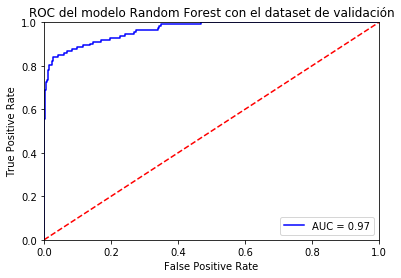

In [42]:
#Calculo del ERR y del umbral de decisión global
err_dev, thresh_dev = evaluate_EER_Thresh(genuine_scores_dev, impostor_scores_dev)


#Ploteamos la curva ROC de los umbrales
plotCurveROC ( genuine_scores_dev, impostor_scores_dev, title = "ROC del modelo Random Forest con el dataset de validación")

### Umbral de decisión global hallado (en formato score)

In [43]:
thresh_dev

array(0.13826751)

### Respectiva tasa de error que nos daria el umbral de decisión

In [44]:
err_dev

0.10949568378000901

In [45]:
users_evaluation_dev['y_pred'] = np.where(users_evaluation_dev['score'] >= thresh_dev, 'genuine', 'impostor')

#users_evaluation_dev.to_excel("./output/outputPredRandomForestDev.xlsx")

#Presentamos el calculo de resultados
users_evaluation_dev

,user_model,user_id,score,std_score,y_test,y_pred
0,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,0.060709,0.060709,genuine,impostor
1,5f778fa22038260004aa67e2,5f7b4cb1b41039000475a738,0.141488,0.141488,impostor,genuine
2,5f778fa22038260004aa67e2,5f84c767ee3df80004f24dda,0.036513,0.036513,impostor,impostor
3,5f778fa22038260004aa67e2,5f77ad46f1051200041f55c8,0.035355,0.035355,impostor,impostor
4,5f778fa22038260004aa67e2,5f77ad46f1051200041f55c8,0.010694,0.010694,impostor,impostor
...,...,...,...,...,...,...
840,5fa9d9dbdd5c300004ce6944,5f793da3beeb150004deab50,0.036463,0.036463,impostor,impostor
841,5fa9d9dbdd5c300004ce6944,5fa494e6e11dde0004c2b8ec,0.003463,0.003463,impostor,impostor
842,5fa9d9dbdd5c300004ce6944,5f778fa22038260004aa67e2,0.039481,0.039481,impostor,impostor
843,5fa9d9dbdd5c300004ce6944,5fa192a2d5ee1c00044d9adf,0.011802,0.011802,impostor,impostor


In [46]:
#Obtenemos los y_test y y_pred de nuestros resultados
y_test_dev = users_evaluation_dev.loc[:, "y_test"]
y_pred_dev = users_evaluation_dev.loc[:, "y_pred"]

### Precisión del umbral hallado con el subdataset de desarrollo

In [47]:
accuracy_score(y_test_dev, y_pred_dev)

0.8875739644970414

# Evaluación del umbral usando el subdataset de PRUEBA

In [48]:
users_evaluation_test = []

for subject in subjects:
    
    #Dataset de entrenamiento
    genuine_data = train_users.loc[(train_users["belongedUserId"] == subject) & (train_users["performedUserId"] == subject) , :]

    impostor_data = train_users.loc[(train_users["belongedUserId"] == subject) & (train_users["performedUserId"] != subject) , :]#.sample(n= genuine_data.shape[0], random_state=43)

    train = pd.concat([genuine_data, impostor_data])
    
    train['y_train'] = np.where(train['performedUserId'] == subject, "genuine", "impostor")

    X_train = train.loc[:, "ft_1":"ft_32" ]
    y_train = train.loc[:, "y_train"]
    
    #----------------------------------------------------------------
    
    #Dataset de desarrollo
    genuine_data = dev_users.loc[(dev_users["belongedUserId"] == subject) & (dev_users["performedUserId"] == subject) , :]

    impostor_data = dev_users.loc[(dev_users["belongedUserId"] == subject) & (dev_users["performedUserId"] != subject) , :]#.sample(n= genuine_data.shape[0], random_state=43)

    dev = pd.concat([genuine_data, impostor_data])

    dev['y_train'] = np.where(dev['performedUserId'] == subject, "genuine", "impostor")

    X_dev = dev.loc[:, "ft_1":"ft_32"]
    y_dev = dev.loc[:, "y_train"]

    #----------------------------------------------------------------

    #Dataset de test
    genuine_data = test_users.loc[(test_users["belongedUserId"] == subject) & (test_users["performedUserId"] == subject) , :]

    impostor_data = test_users.loc[(test_users["belongedUserId"] == subject) & (test_users["performedUserId"] != subject) , :]#.sample(n= genuine_data.shape[0], random_state=43)

    test = pd.concat([genuine_data, impostor_data])

    test['y_train'] = np.where(test['performedUserId'] == subject, "genuine", "impostor")

    X_test = test.loc[:, "ft_1":"ft_32"]
    y_test = test.loc[:, "y_train"]
    
    #----------------------------------------------------------------
    
    if not train.empty:
        
        #Entrenamos el modelo
        
        clf = RandomForestClassifier(random_state = 43, max_depth= 10, 
                                 max_features= 'auto',  min_samples_leaf= 1,
                                   min_samples_split= 5, n_estimators= 1300)

        clf.fit(X_train,y_train)
        
        #Obtenemos probabilidades de cada registro del dataset de test
        y_prob = clf.predict_proba(X_test)

        y_prob = pd.DataFrame(y_prob, columns = [ f'prob_{clf.classes_[0]}', f'prob_{clf.classes_[1]}'])
        
        i = 0

        #Para cada registro del subdataset de test
        for index, row in test.iterrows():

            temp_obj = {}

            #user id del registro actual del subdataset de test
            current_user_id = row[1]

            #Vector de tiempo del registro actual del subdataset de test
            current_data = row[3:]


            #Actual modelo del usuario a evaluar
            temp_obj["user_model"] = subject

            #user id del registro actual
            temp_obj["user_id"] = current_user_id

            #Puntaje o score del modelo
            temp_obj["score"] = y_prob.iloc[i]["prob_genuine"]

            #Normalizacion del score
            temp_obj["std_score"] = y_prob.iloc[i]["prob_genuine"]

            #Variable que indica si el registro deberia de ser clasificado como genuino o impostor
            if current_user_id == subject:
                temp_obj["y_test"] = "genuine"
            else:
                temp_obj["y_test"] = "impostor"

            users_evaluation_test.append(temp_obj)

            i += 1

users_evaluation_test = pd.DataFrame(users_evaluation_test)

### Puntaje de los registros del subdataset de test usando todos los modelos
 - **user_model:** modelo del usuario empleado para sacar el score
 - **user_id:** usuario del registro evaluado
 - **score:** puntuación que le dió el modelo
 - **std_score:** puntuación normalizada
 - **y_test:** cuando el user_model y user_id coinciden, entonces se usó un registro de usuario considerado genuino; caso contrario, es de un impostor

In [49]:
# OJO, aca se esta usando el score como umbral, si usaramos el score estandarizado, deberiamos de cambiar el sentido de la comparación
users_evaluation_test['y_pred'] = np.where(users_evaluation_test['score'] >= thresh_dev, 'genuine', 'impostor')

#users_evaluation_test.to_excel("./output/outputPredRandomForestTest.xlsx")

#Presentamos el calculo de resultados
users_evaluation_test

,user_model,user_id,score,std_score,y_test,y_pred
0,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,0.183294,0.183294,genuine,genuine
1,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,0.356933,0.356933,genuine,genuine
2,5f778fa22038260004aa67e2,5f7791082038260004aa67e3,0.008654,0.008654,impostor,impostor
3,5f778fa22038260004aa67e2,5f7791082038260004aa67e3,0.021544,0.021544,impostor,impostor
4,5f778fa22038260004aa67e2,5f7c8379859bc10004908e42,0.009559,0.009559,impostor,impostor
...,...,...,...,...,...,...
889,5fa9d9dbdd5c300004ce6944,5f7be1ec908cb60004943ced,0.071027,0.071027,impostor,impostor
890,5fa9d9dbdd5c300004ce6944,5f8b1d7f146ea70004046106,0.112651,0.112651,impostor,impostor
891,5fa9d9dbdd5c300004ce6944,5fa06c9299afb80004ca7121,0.019720,0.019720,impostor,impostor
892,5fa9d9dbdd5c300004ce6944,5fa6fe1f10f2650004605b73,0.032258,0.032258,impostor,impostor


In [50]:
#Obtenemos los y_test y y_pred de nuestros resultados
y_test_test = users_evaluation_test.loc[:, "y_test"]
y_pred_test = users_evaluation_test.loc[:, "y_pred"]

# Resultados
### Precisión del umbral hallado

In [51]:
accuracy_score(y_test_test, y_pred_test)

0.8736017897091722

### Curva ROC

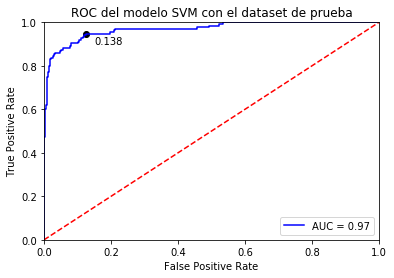

In [52]:
#Obtenemos la listas de scores de los registros que deberian de catalogarse como genuinos por los modelos
genuine_scores_test = list(users_evaluation_test.loc[users_evaluation_test.y_test == "genuine", "score"])

#Obtenemos la listas de scores de los registros que deberian de catalogarse como impostores por los modelos
impostor_scores_test = list(users_evaluation_test.loc[users_evaluation_test.y_test == "impostor", "score"])

thresh_x, thresh_y, _ = find_fpr_and_tpr_given_a_threshold(genuine_scores_test, impostor_scores_test, thresh_dev)

thresh_std = round(thresh_dev.tolist(), 3)

#Ploteamos la curva ROC
plotCurveROC_Threshold( genuine_scores_test, impostor_scores_test, thresh_std, thresh_x, thresh_y, "black",  title = "ROC del modelo SVM con el dataset de prueba")

In [53]:
report = classification_report(y_test_test, y_pred_test, labels = [ "genuine", "impostor"])
cm = confusion_matrix(y_test_test, y_pred_test, labels = [ "genuine", "impostor"])
accuracy = accuracy_score(y_test_test, y_pred_test)
recall = recall_score(y_test_test, y_pred_test, pos_label  = "genuine")
f1 = f1_score(y_test_test, y_pred_test, pos_label  = "genuine")
print(f'{model_name}')
print("Accuracy", accuracy)
print("Recall", recall)
print("F1", f1)
print(report)
print(cm)

Random Forest
Accuracy 0.8736017897091722
Recall 0.9485294117647058
F1 0.6954177897574124
              precision    recall  f1-score   support

     genuine       0.55      0.95      0.70       136
    impostor       0.99      0.86      0.92       758

    accuracy                           0.87       894
   macro avg       0.77      0.90      0.81       894
weighted avg       0.92      0.87      0.89       894

[[129   7]
 [106 652]]


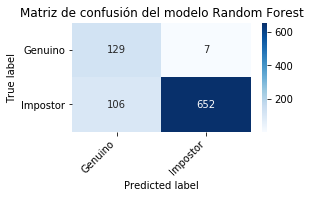

In [54]:
cm = confusion_matrix(y_test_test, y_pred_test, labels = [ "genuine", "impostor"])
print_confusion_matrix(cm, ["Genuino", "Impostor"], title = f'Matriz de confusión del modelo {model_name}', figsize = (4,2), fontsize=10)

### TEST

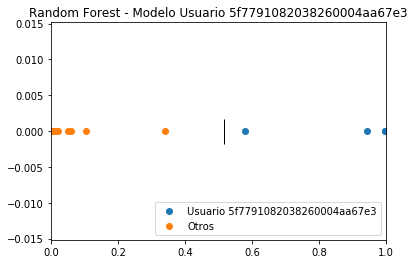

In [55]:
plt.title(f'{model_name} - Modelo Usuario 5f7791082038260004aa67e3')

sc1 = users_evaluation_dev.loc[(users_evaluation_dev.user_model == "5f7791082038260004aa67e3") & (users_evaluation_dev.user_id == "5f7791082038260004aa67e3"), "std_score"]
sc2 = users_evaluation_dev.loc[(users_evaluation_dev.user_model == "5f7791082038260004aa67e3") & (users_evaluation_dev.user_id != "5f7791082038260004aa67e3"), "std_score"]

y1 = np.zeros(len(sc1))
y2 = np.zeros(len(sc2))

plt.scatter(sc1, y1, label = "Usuario 5f7791082038260004aa67e3")
plt.scatter(sc2, y2, label = "Otros")

plt.plot(0.51540077, 0, marker= "|", color = "blacK", markersize= 25)

plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.show()